In [ ]:
# default_exp core

# Core

> Basic functions and classes usful to reproduce research papers.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import requests
from fastcore.all import *
from fastai.data.all import *
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.basics import *
from fastai.vision.gan import *
from fastai.vision.models.all import *
from fastai.vision.augment import *
from fastai.callback.hook import *
from fastai.vision.widgets import *

## Explode Functions

These are function that are useful for debugging.

In [ ]:
#export
def explode_types(o):
    '''Like fastcore explode_types, but only shows __name__ of type.'''
    if not is_listy(o): return type(o).__name__
    return {type(o).__name__: [explode_types(o_) for o_ in o]}

In [ ]:
#export
def explode_lens(o):
    if is_listy(o):
        if all(is_listy(o_) for o_ in o):
            return [explode_lens(o_) for o_ in o]
        else: return len(o)

In [ ]:
test_eq(explode_lens([[1,4], [[5,6,7], [1]]]), [2, [3, 1]])

In [ ]:
#export
def explode_shapes(o):
    if not is_listy(o): return tuple(bind(getattr, arg0, 'shape')(o))
    return [explode_shapes(o_) for o_ in o]

In [ ]:
test_eq(explode_shapes([tensor([1,4]), [tensor([[4,5],[7,8]]), tensor([6])]]), [(2,), [(2,2), (1,)]])

In [ ]:
#export
def explode_ranges(o):
    if not is_listy(o): return (float(o.min()), float(o.max()))
    return [explode_ranges(o_) for o_ in o]

In [ ]:
explode_ranges([tensor([1,4]), [tensor([[4,5],[7,8]]), tensor([6])]])

[(1.0, 4.0), [(4.0, 8.0), (6.0, 6.0)]]

In [ ]:
#export
def pexpt(o): print(explode_types(o))

In [ ]:
#export
def pexpl(o): print(explode_lens(o))

In [ ]:
#export
def pexps(o): print(explode_shapes(o))

In [ ]:
#export
def receptive_fields(model, nf, imsize, bs=64):
    '''returns the size of the receptive field for each feature output.'''
    x = dummy_eval(model, imsize).detach()
    outsz = x.shape[-2:]
    for p in model.named_parameters():
        if 'weight' in p[0]:
            n = p[1].shape[1] if len(p[1].shape)==4 else 1
            nn.init.constant_(p[1], 1./n)
        elif 'bias' in p[0]:
            nn.init.constant_(p[1], 0)

    with torch.no_grad():
        rfs = []
        model.eval()
        model = model.cuda()
        t = torch.eye(imsize[0]**2).reshape(imsize[0]*imsize[1], 1, imsize[0], imsize[1])
        for i,batch in enumerate(chunked(t, bs)):
            new = torch.cat(batch, dim=0).unsqueeze(1)
            new = torch.cat([new for _ in range(nf)], dim=1).cuda()
            rfs.append(model(new).cpu())
    rfs = torch.cat(rfs, dim=0).squeeze()
    rfs = rfs.reshape(imsize[0], imsize[1], outsz[0], outsz[1])
    rfs = (rfs>0.99).sum(axis=(0,1)).float().sqrt()
    return rfs

## N Images Classes

These are classes to handle many images to many images generation

In [ ]:
#export 
class ImageNTuple(fastuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        all_tensors = all([isinstance(t, Tensor) for t in self])
        same_shape = all([self[0].shape==t.shape for t in self[1:]])
        if not all_tensors or not same_shape: return ctx
        line = self[0].new_zeros(self[0].shape[0], self[0].shape[1], 10)
        imgs = sum(L(zip(self, [line]*len(self))).map(list),[])[:-1]
        return show_image(torch.cat(imgs, dim=2), ctx=ctx, **kwargs)
    
    def requires_grad_(self, value):
        for item in self: item.requires_grad_(value)
        return self

    def detach(self):
        for item in self: item.detach()
        return self


In [ ]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

ImageNTuple will only show tha images if all of them are of same size, and if all of them are tensors.

In [ ]:
imt2 = ImageNTuple.create((files[0], files[1]))
explode_types(imt2)

{'ImageNTuple': ['PILImage', 'PILImage']}

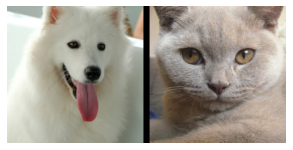

In [ ]:
imt2 = ImageNTuple.create((files[0], files[1]))
imt2 = Resize(224)(imt2)
imt2 = ToTensor()(imt2)
imt2.show();

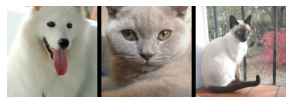

In [ ]:
imt3 = ImageNTuple.create((files[0], files[1], files[2]))
imt3 = Resize(224)(imt3)
imt3 = ToTensor()(imt3)
ax = imt3.show()

In [ ]:
test_eq(len(imt2), 2)
test_eq(len(imt3), 3)

In [ ]:
# export
def ImageTupleBlock(): 
    '''Like fastai tutoria siemese transform, but uses ImageNTuple.'''
    return TransformBlock(type_tfms=ImageNTuple.create, batch_tfms=[IntToFloatTensor])

## Conditional Generator

In [ ]:
#export
class ConditionalGenerator(nn.Module):
    '''Wraper around a GAN generator that returns the generated image and the input.'''
    def __init__(self, gen):
        super().__init__()
        self.gen = gen
    def forward(self, x):
        if is_listy(x):
            input = torch.cat(x, axis=1)
        else:
            input = x
        return ImageNTuple(x, TensorImage(self.gen(input)))

Test that the ConditionalGenerator can generate images from one image

In [ ]:
gen_base = basic_critic(32, 3)
gen_base = nn.Sequential(*list(gen_base.children())[:-2])
unet = DynamicUnet(gen_base, 3, (32, 32))
gen = ConditionalGenerator(unet)

In [ ]:
out = gen(torch.rand(1, 3, 32, 32))

In [ ]:
test_eq(explode_shapes(out), [(1, 3, 32, 32), (1, 3, 32, 32)])

In [ ]:
test_eq(type(out), ImageNTuple)

Test that the ConditionalGenerator can generate an image from two images

In [ ]:
gen_base = basic_critic(32, 6)
gen_base = nn.Sequential(*list(gen_base.children())[:-2])
unet = DynamicUnet(gen_base, 3, (32, 32))
gen = ConditionalGenerator(unet)

In [ ]:
dl = DataLoader(dataset=([imt2]), bs=1, after_item=IntToFloatTensor())
b = first(dl)
out = gen(b)

In [ ]:
test_eq(type(out), ImageNTuple)
test_eq(len(out), 3)

## Siamese Critic

In [ ]:
#export
class SiameseCritic(Module):
    def __init__(self, critic): self.critic = critic
    def forward(self, x): return self.critic(torch.cat(x, dim=1))

In [ ]:
critic = gan_critic(n_channels=6, nf=64)
scritic = SiameseCritic(critic)

## GAN Metrics

These are Metrics that work with GANLearner

In [ ]:
#export
class GenMetric(AvgMetric):
    def accumulate(self, learn):
        if learn.model.gen_mode:
            bs = find_bs(learn.yb)
            self.total += to_detach(self.func(learn, learn.pred, *learn.yb))*bs
            self.count += bs

In [ ]:
#export
class CriticMetric(AvgMetric):
    def accumulate(self, learn):
        if not learn.model.gen_mode:
            bs = find_bs(learn.yb)
            self.total += to_detach(self.func(learn, learn.pred, *learn.yb))*bs
            self.count += bs

In [ ]:
#export
def l1(learn, output, target): return nn.L1Loss()(output[-1], target[-1])
l1 = GenMetric(l1)

## ProgressImage Callback
This callback shows a sample of the generator after every epoch. It is a good idea to keep a human in the loop.

In [ ]:
#export
class ProgressImage(Callback):
    @delegates(show_image)
    def __init__(self, out_widget, save_img=False, folder='pred_imgs', conditional=False, **kwargs):
        self.out_widget = out_widget
        self.kwargs = kwargs
        self.save_img = save_img
        self.folder = folder
        self.conditional = conditional
        if self.conditional:
            self.title = 'input/real/fake'
        else:
            self.title = 'generated'
        Path(self.folder).mkdir(exist_ok=True)
    def before_fit(self):
        with self.out_widget:
            self.fig, self.ax = plt.subplots()
            self.ax.axis('off')        
    def before_batch(self):
        if self.gan_trainer.gen_mode and self.training: self.last_gen_target = self.learn.yb[0][-1]
    def after_epoch(self):
        "Show a sample image."
        if not hasattr(self.learn.gan_trainer, 'last_gen'): return
        b = self.learn.gan_trainer.last_gen
        gt = self.last_gen_target
        gt, b = self.learn.dls.decode((gt, b))
        gt, imt = batch_to_samples((gt, b), max_n=1)[0]
        if self.conditional:
            imt = ToTensor()(ImageNTuple.create((imt[0], gt, imt[-1])))
        self.out_widget.clear_output(wait=True)
        with self.out_widget:
            self.ax.clear()
            imt.show(ax=self.ax, title=self.title, **self.kwargs)
            display(self.fig)
        if self.save_img: self.fig.savefig(self.path / f'{self.folder}/pred_epoch_{self.epoch}.png')

## Show Results for TupleNImage

In [ ]:
#export
@typedispatch
def show_results(x:TensorImage, y:ImageNTuple, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    max_n = min(x.shape[0], max_n)
    if max_n<ncols: ncols = max_n
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = 'Input-Real-Fake'
        ImageNTuple(x[i], y[1][i], outs[i][0][1]).show(ctx=ctx, title=title)

## Tuple in Ys Learner Fix

Learner.show_results and Learner.predict thowgh an error if the ys are tuples. Let's fix that

In [ ]:
#export
@patch
def show_results(self:GANLearner, ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
    if dl is None: dl = self.dls[ds_idx].new(shuffle=shuffle)
    b = dl.one_batch()
    _,_,preds = self.get_preds(dl=[b], with_decoded=True)
    preds = (preds,)
    self.dls.show_results(b, preds, max_n=max_n, **kwargs)

In [ ]:
#exort
@patch
def predict(self:GANLearner, item, rm_type_tfms=None, with_input=False):
    dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
    inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
    i = getattr(self.dls, 'n_inp', -1)
    inp = (inp,) if i==1 else tuplify(inp)
    n_out = len(self.dls.tls) - i
    dec_preds = (dec_preds,) if n_out==1 else tuplify(dec_preds)
    dec = self.dls.decode_batch(inp + dec_preds)[0]
    dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
    res = dec_targ,dec_preds[0],preds[0]
    if with_input: res = (dec_inp,) + res
    return res

## Datasets

In [ ]:
#export
URLs.FACADES = 'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz'
URLs.FACADES_BASE = 'http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip'
URLs.FACADES_EXTENDED = 'http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip'
URLs.CELEBA = '0B7EVK8r0v71pZjFTYXZWM3FlRnM'

In [ ]:
#export
def download_file_from_google_drive(file_id, destination, folder_name=None):
    if folder_name:
        dst = Config()['data'] / folder_name
        if dst.exists():
            return dst
    else:
        dst = Config()['data']
    arch_dst = Config()['archive'] / destination
    if not arch_dst.exists(): 
        URL = "https://docs.google.com/uc?export=download"
        session = requests.Session()
        response = session.get(URL, params = { 'id' : file_id }, stream = True)
        token = first([(k,v) for k,v in response.cookies.items() if k.startswith('download_warning')])[1]
        if token:
            params = { 'id' : file_id, 'confirm' : token }
            response = session.get(URL, params = params, stream = True)
        save_response_content(response, Config()['archive'] / destination)
    file_extract(Config()['archive'] / destination, Config()['data'])
    return dst

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

Original Inveptions Weights for FID by mseitzer

In [ ]:
#export
FID_WEIGHTS_URL = 'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_isola2017image.ipynb.
Converted 02_heusel2017gans.ipynb.
Converted index.ipynb.
